<a href="https://colab.research.google.com/github/Lit-IFRN/PreverChuvaSemPegadinha/blob/main/Prever_Chuva_sem_pegadinha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#Imports

In [ ]:
data = pd.read_csv('data.csv', date_parser = True)
data = data.filter(['DT_MEDICAO', 'CHUVA'], axis=1)
data.tail()
# udud

,DT_MEDICAO,CHUVA
5011,2020-09-26,0.4
5012,2020-09-27,0.0
5013,2020-09-28,1.0
5014,2020-09-29,0.0
5015,2020-09-30,0.0


In [ ]:
data_test = data[data['DT_MEDICAO']>='2018-01-01'].copy()
data_training = data[data['DT_MEDICAO']<'2020-01-01'].copy()

#data_test = data_training.tail(182).append(data_test)
data_test = data_test.drop(['DT_MEDICAO'], axis = 1)
data_training = data_training.drop(['DT_MEDICAO'], axis = 1)


In [ ]:
data_test.shape

(1004, 1)

In [ ]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)


array([[0.00486855],
       [0.        ],
       [0.07010711],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [ ]:
X_train = []
y_train = []

for i in range(182, data_training.shape[0]):
    X_train.append(data_training[i-182:i])
    y_train.append(data_training[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.layers.advanced_activations import LeakyReLU


In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 182, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(LSTM(units = 91, activation = 'relu', return_sequences = True))
regressor.add(LSTM(units = 182, activation = 'relu', return_sequences = False))

regressor.add(Dense(units = 1))


In [ ]:
regressor.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
regressor.fit(X_train, y_train, epochs=5, batch_size=2)


Epoch 1/5
2280/2280 [==============================] - 825s 362ms/step - loss: 0.0037 - accuracy: 0.5325
Epoch 2/5
2280/2280 [==============================] - 824s 361ms/step - loss: 0.0037 - accuracy: 0.5325
Epoch 3/5
2280/2280 [==============================] - 817s 358ms/step - loss: 0.0036 - accuracy: 0.5325
Epoch 4/5
2280/2280 [==============================] - 826s 362ms/step - loss: 0.0036 - accuracy: 0.5325
Epoch 5/5
2280/2280 [==============================] - 821s 360ms/step - loss: 0.0035 - accuracy: 0.5325


In [ ]:
inputs = scaler.transform(data_test)

In [ ]:
X_test = []
y_test = []

for i in range(182, inputs.shape[0]):
    X_test.append(inputs[i-182:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((822, 182, 1), (822,))

In [ ]:
y_pred = regressor.predict(X_test)


In [ ]:
y_pred = scaler.inverse_transform(y_pred)

In [ ]:
#scale = 1/0.00486855

In [ ]:
#scale

205.39996508200593

In [ ]:
#y_pred = y_pred*scale
#y_test = y_test*scale

In [ ]:
y_test

array([  0.        ,   1.79999969,   0.        ,   0.        ,
        14.19999759,  82.39998599,   0.5999999 ,   0.        ,
        33.19999436,  43.79999255,  10.79999816,  17.99999694,
         1.39999976,   0.        ,   0.        ,   0.        ,
         1.59999973,   2.39999959,   0.        ,   0.39999993,
         0.79999986,   0.        ,   0.        ,   0.        ,
         0.        ,  20.5999965 ,   0.99999983,   0.79999986,
         1.79999969,   0.99999983,   0.5999999 ,   0.79999986,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   1.39999976,   1.1999998 ,
         3.59999939,   6.59999888,   0.        ,   0.        ,
         0.        ,   0.        ,   5.39999908,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  13.39999772,   1.59999973,
         0.        ,   0.79999986,   0.        ,   0.19999997,
         0.        ,   0.        ,   2.39999959,   0.39

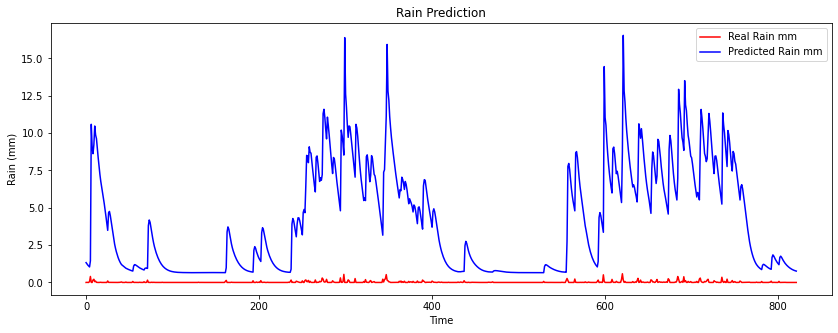

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Rain mm')
plt.plot(y_pred, color = 'blue', label = 'Predicted Rain mm')

plt.title('Rain Prediction')
plt.xlabel('Time')
plt.ylabel('Rain (mm)')
plt.legend()
plt.show()

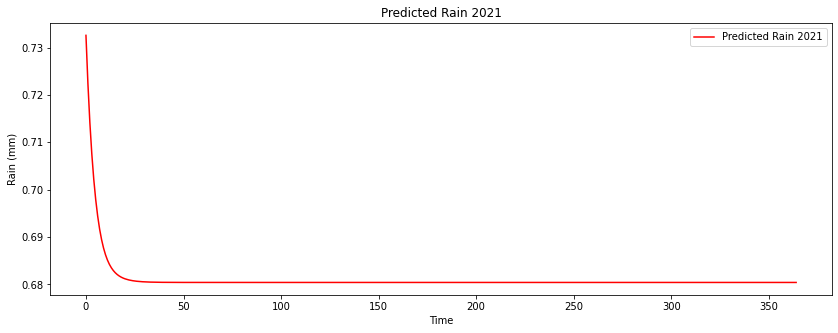

In [ ]:
# Get last 182 days to predict tomorrow
necessaryDataToPredict = data.tail(182).drop("DT_MEDICAO", axis=1)

# Scale the last 182 days to between 0 and 1
scaledNecessaryDataToPredict = scaler.transform(necessaryDataToPredict)

# Convert the last 182 days to numpy array
npArrayScaledNecessaryDataToPredict = np.array([scaledNecessaryDataToPredict])

# Predict value
predicts = regressor.predict(npArrayScaledNecessaryDataToPredict)

# Revert predict scale (it was between 0 and 1 and now is the real value)

predictedValues = []

for i in range(0, 365):
  alo = np.append(npArrayScaledNecessaryDataToPredict[0], predicts, axis=0)
  alo = np.delete(alo, 0, axis=0)
  npArrayScaledNecessaryDataToPredict[0] = alo
  npArrayScaledNecessaryDataToPredict

  predicts = regressor.predict(npArrayScaledNecessaryDataToPredict)
  predictedValues.append(predicts[0])

predictedValues = np.array(predictedValues)
predictedValues *= scale
predictedValues

plt.figure(figsize=(14,5))
plt.plot(predictedValues, color = 'red', label = 'Predicted Rain 2021')
plt.title('Predicted Rain 2021')
plt.xlabel('Time')
plt.ylabel('Rain (mm)')
plt.legend()
plt.show()